In [99]:
from pyscf import gto, scf, mcscf
from pyscf.mcscf import apc
import matplotlib as mpl
import matplotlib.pyplot as plt
import math

# Changing the initial guess
Last time, I was investigating spin state and found that the relative energy of the lowest triplet state varied quite a lot depending on the choice of starting guess (RHF, UHF, ROHF) and active space size. I want to try altering the initial guess (and therefore the initial orbitals) to see how much of an effect that has on the energies

In [2]:
geom = """
O1  0.0000  0.0000  0.0000;
O2  1.0833  0.6667  0.0000;
O3 -1.0833  0.6667  0.0000;
"""

In [3]:
basis_sets = {"TZVP": "def2-tzvp",}

In [4]:
results = {}

Going to try SCAN0, a hybrid meta GGA functional. The parent SCAN mGGA is a (heavy airquotes) "parameter-free" functional that has been constructed to meet a quite a lot of known exact constraints on the functional. SCAN0 replaces 25% of the exchange with exact exchange (e.g. HF exchange).

In [5]:
mf_methods = {"singlet RKS": {"2S": 0, "mf": scf.RKS, "xc": "SCAN0"},
              "triplet UKS": {"2S": 2, "mf": scf.UKS, "xc": "SCAN0"},
              "triplet ROKS": {"2S": 2, "mf": scf.ROKS, "xc": "SCAN0"},}

In [6]:
for mult, method in mf_methods.items():        
    for basis, basis_set in basis_sets.items():
        mol = gto.M(atom=geom, basis=basis_set, spin=method["2S"]).build()
        mol.xc = method["xc"]
        name = f"{mult}: {method['xc']}/{basis}"
        mf = method["mf"](mol).density_fit()
        mf.kernel()
        results[name] = {"mol": mol, "mf": mf}

/Users/ch1tk/PROJECTS/ozone/.venv/lib/python3.11/site-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


converged SCF energy = -223.961312961227
converged SCF energy = -223.906538257701  <S^2> = 2.0034924  2S+1 = 3.0023274
converged SCF energy = -223.90507047673


In [7]:
for name, result in results.items():
    print(f"{name}: {result['mf'].e_tot}")

singlet RKS: SCAN0/TZVP: -223.96131296122667
triplet UKS: SCAN0/TZVP: -223.90653825770067
triplet ROKS: SCAN0/TZVP: -223.90507047672986


* Remember that we can only compare the relative energies of the states between the HF and SCAN0 results, as the lower bound of the KS energy depends on the choice of functional. Since we aren't using the exact XC functional, it's virtually meaningless to compare the absolute HF and SCAN0 energies.
* The singlet-triplet gaps are $\sim0.01\ E_h$ and $\sim0.04\ E_h$ for RHF/UHF and RHF/ROHF respectively
* For SCAN0, they are much larger and closer together, both around $\sim0.05\ E_h$, which is closer to the CAS(6,6) results ($\sim0.04\ E_h$)

In [46]:
for mult, method in mf_methods.items():        
    for basis, basis_set in basis_sets.items():
        mf_name = f"{mult}: {method['xc']}/{basis}"
        for n_elec in [4, 6, 8]:
            cas_name = f"{mult}: CAS({n_elec}/{n_elec})SCF//{method['xc']}/{basis}"
            if results.get(cas_name) is None:
                mc = mcscf.DFCASSCF(results[mf_name]["mf"], n_elec, n_elec)
                mc.kernel()
                results[cas_name] = mc

CASSCF energy = -224.481747343791
CASCI E = -224.481747343791  E(CI) = -6.00357228093978  S^2 = 0.0000000
CASSCF energy = -224.586608116983
CASCI E = -224.586608116983  E(CI) = -20.5258519067391  S^2 = 0.0000000
CASSCF energy = -224.444705250077
CASCI E = -224.444705250077  E(CI) = -5.99975679635264  S^2 = 2.0000000
CASSCF energy = -224.532012727735
CASCI E = -224.532012727735  E(CI) = -20.6723874671266  S^2 = 2.0000000
CASSCF energy = -224.444705257615
CASCI E = -224.444705257615  E(CI) = -5.99956256798083  S^2 = 2.0000000
CASSCF energy = -224.512239952218
CASCI E = -224.512239952218  E(CI) = -20.4965730369311  S^2 = 2.0000000


In [47]:
for mult, method in mf_methods.items():        
    for basis, basis_set in basis_sets.items():
        for n_elec in [4, 6, 8]:
            cas_name = f"{mult}: CAS({n_elec}/{n_elec})SCF//{method['xc']}/{basis}"
            print(f"{cas_name}: {results[cas_name].e_tot}")

singlet RKS: CAS(4/4)SCF//SCAN0/TZVP: -224.4817473437911
singlet RKS: CAS(6/6)SCF//SCAN0/TZVP: -224.5258564016024
singlet RKS: CAS(8/8)SCF//SCAN0/TZVP: -224.58660811698326
triplet UKS: CAS(4/4)SCF//SCAN0/TZVP: -224.44470525007728
triplet UKS: CAS(6/6)SCF//SCAN0/TZVP: -224.4817028089315
triplet UKS: CAS(8/8)SCF//SCAN0/TZVP: -224.53201272773504
triplet ROKS: CAS(4/4)SCF//SCAN0/TZVP: -224.44470525761463
triplet ROKS: CAS(6/6)SCF//SCAN0/TZVP: -224.48170280896326
triplet ROKS: CAS(8/8)SCF//SCAN0/TZVP: -224.51223995221778


These results are identical (within convergence critera) to the results using HF references.

# Automated active space selection

PySCF has a couple of automated active space selection methods. From the reading I've done, two of them (AVAS and DMET) seem to be based on specifying some atomic orbitals that you expect the important MOs to be based on, and there is another called APC which uses entropy metrics to estimate which orbitals are the important ones. This reminds me of some other active space selection methods that used entaglement that I believe were used for automatic DMRG calculations but I can't remember the specifics. I'm going to try APC for now since that seems most relevant to ozone.

In [10]:
results_apc = {}

In [12]:
mf = results['singlet RKS: SCAN0/TZVP']['mf']
for max_size in range(4, 13):
    myapc = apc.APC(mf, max_size=max_size)
    n_cas, n_elec_cas, cas_orbs = myapc.kernel()
    mc = mcscf.DFCASSCF(mf, n_cas, n_elec_cas)
    mc.mo_coeff = cas_orbs
    mc.kernel()
    results_apc[max_size] = mc


** APC Active Space Selection **
Calculating APC entropies (N=2)...
Transforming F and K to MO basis...
Calculating initial APC entropies...
Maximum entropy: 0.68996
Setting maximum virtual orbitals [14] to occupation 1...
Calculating APC entropies (Round 1)...
Maximum entropy: 0.69247
Setting maximum virtual orbitals [14, 13] to occupation 1...
Calculating final APC entropies...
Maximum entropy: 0.69411
Choosing active space with ranked orbital approach (max_size = 4)...
Final selected active space: ((2, 2),4)
CASSCF energy = -224.419246143133
CASCI E = -224.419246143133  E(CI) = -7.42364114866425  S^2 = 0.0000000

** APC Active Space Selection **
Calculating APC entropies (N=2)...
Transforming F and K to MO basis...
Calculating initial APC entropies...
Maximum entropy: 0.68996
Setting maximum virtual orbitals [14] to occupation 1...
Calculating APC entropies (Round 1)...
Maximum entropy: 0.69247
Setting maximum virtual orbitals [14, 13] to occupation 1...
Calculating final APC entro

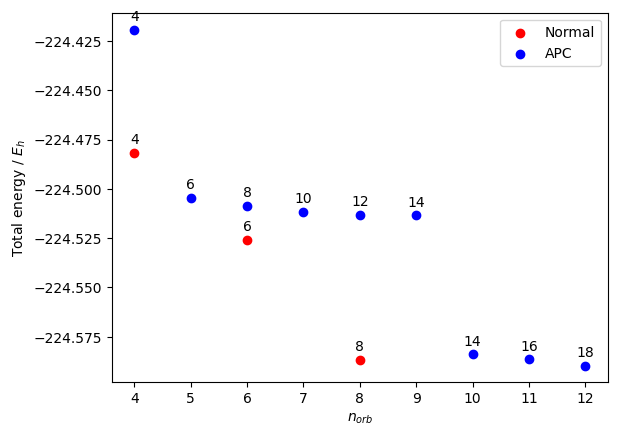

In [88]:
fig, ax = plt.subplots()
normal_n_orb = [4, 6, 8]
normal_e_tot = [results[f"singlet RKS: CAS({n_orb}/{n_orb})SCF//SCAN0/TZVP"].e_tot for n_orb in [4, 6, 8]]
normal_nelecas = [results[f"singlet RKS: CAS({n_orb}/{n_orb})SCF//SCAN0/TZVP"].nelecas[0] * 2 for n_orb in [4, 6, 8]]
ax.scatter(x=normal_n_orb, y=normal_e_tot, color='red', label='Normal')
for i in range(len(normal_n_orb)):
    ax.annotate(normal_nelecas[i], (normal_n_orb[i], normal_e_tot[i] + 0.003), va='bottom', ha='center')
apc_n_orb = range(4, 13)
apc_e_tot = [results_apc[i].e_tot for i in range(4, 13)]
apc_nelecas = [results_apc[i].nelecas[0] * 2 for i in range(4, 13)]
ax.scatter(x=apc_n_orb, y=apc_e_tot, color='blue', label='APC')
for i in range(len(apc_n_orb)):
    ax.annotate(apc_nelecas[i], (apc_n_orb[i], apc_e_tot[i] + 0.003), va='bottom', ha='center')
ax.set_ylabel("Total energy / $E_{h}$")
ax.set_xlabel("$n_{orb}$")
ax.legend()
plt.show()

These results are quite disappointing. It seems like the naive approach of energy ordering yields better results than using APC. I haven't really been paying attention to execution times, so perhaps in terms of CSFs the APC results are more efficient?

In [122]:
def n_csfs(n_orb: int, n_elec: int, spin: int):
    return (2*spin + 1) / (n_orb + 1) * math.comb(n_orb + 1, n_elec//2 - spin) * math.comb(n_orb + 1, n_elec//2 + spin + 1)
    

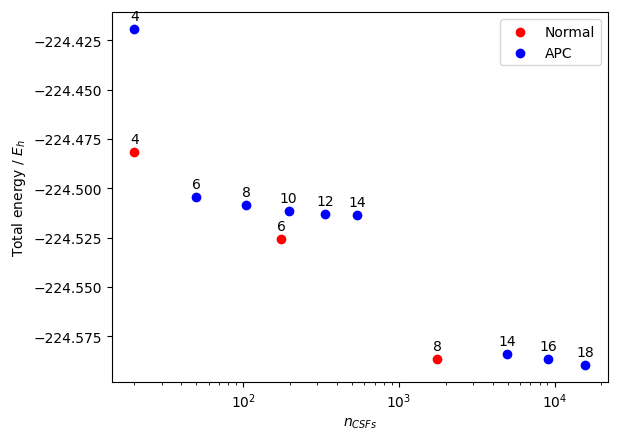

In [123]:
fig, ax = plt.subplots()
normal_n_csf = [n_csfs(4, 4, 0), n_csfs(6, 6, 0), n_csfs(8, 8, 0)]
ax.scatter(x=normal_n_csf, y=normal_e_tot, color='red', label='Normal')
for i in range(len(normal_n_orb)):
    ax.annotate(normal_nelecas[i], (normal_n_csf[i], normal_e_tot[i] + 0.003), va='bottom', ha='center')
apc_n_csf = [n_csfs(i, results_apc[i].nelecas[0] * 2, 0) for i in range(4, 13)]
ax.scatter(x=apc_n_csf, y=apc_e_tot, color='blue', label='APC')
for i in range(len(apc_n_orb)):
    ax.annotate(apc_nelecas[i], (apc_n_csf[i], apc_e_tot[i] + 0.003), va='bottom', ha='center')
ax.set_ylabel("Total energy / $E_{h}$")
ax.set_xlabel("$n_{CSFs}$")
ax.set_xscale("log")
ax.legend()
plt.show()

Again, quite disappointing. APC doesn't seem to be able to choose more efficient representations. Perhaps I'm misunderstanding this but it seems like the naive approach is more effective.